In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import plotFunctions as plotFunc
from neurolib.utils import costFunctions as cost
import neurolib.dashboard.functions as functions
import neurolib.dashboard.data as data
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

not here


In [2]:
grid_data_file = os.path.join(os.getcwd().split('data')[0], 'bi.pickle')
with open(grid_data_file,'rb') as f:
    load_array= pickle.load(f)
exc = [load_array[0][20], load_array[0][50]]
inh = [load_array[1][20], load_array[1][50]]

folder = str(os.getcwd().split('data_2')[1])
print(folder)
case = str(folder[1])

file_ = 'up.pickle'

c_var = [0,1]
if len(folder) == 4:
    if folder[3] == 'e':
        p_var = [0]
    elif folder[3] == 'i':
        p_var = [1]
else:
    p_var = [0,1]
    
print(p_var)

step1 = 1
step2 = 10
step3 = 100

/2_i
[1]


In [3]:
aln = ALNModel()
N = aln.params.N

data.set_parameters(aln)

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

In [4]:
d_array = np.arange(20., 300, 0.1)
t0_array = d_array - 20.
t_pen = np.zeros(( t0_array.shape ))
for i in range(len(t_pen)):
    t_pen[i] = t0_array[i] / d_array[i] 

In [5]:
dur_pre = 10
dur_post = 10

n_pre = int(np.around(dur_pre/aln.params.dt + 1.,1))
n_post = int(np.around(dur_post/aln.params.dt + 1.,1))

tol = 1e-8
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

if case in ['1', '2']:    # low to high
    max_I = [3., -3.]
else:
    max_I = [-3., 3.]
    
if case in ['1', '3']:    # sparsity
    factor_ws = 1.
    factor_we = 0.
    cost_index = 2
else:
    factor_ws = 0.
    factor_we = 1.
    cost_index = 1
    
maxC = [1000., -1000., 0.18, 0.]
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

In [6]:
bestControl_ = np.array( [[None] * len(t_pen)] * len(exc) )
bestState_ = np.array( [[None] * len(t_pen)] * len(exc) )
cost_ = np.array( [[None] * len(t_pen)] * len(exc) )
costnode_ = np.array( [[None] * len(t_pen)] * len(exc) )
weights_ = np.array( [[None] * len(t_pen)] * len(exc) )
convergence_ = np.array( [[None] * len(t_pen)] * len(exc) )

initVars = [None] * len(exc)
target = [None] * len(exc)
cost_uncontrolled = [None] * len(exc)

print(bestControl_.shape)

(2, 2800)


In [7]:
if os.path.isfile(file_) :
    print("file found")
    
    with open(file_,'rb') as f:
        load_array = pickle.load(f)

    bestControl_ = load_array[0]
    bestState_ = load_array[1]
    cost_ = load_array[2]
    costnode_ = load_array[3]
    weights_ = load_array[4]

file found


In [8]:
# get initial parameters and target states
# -------  20 0.4500000000000001 0.4750000000000002
#-------  50 0.47500000000000014 0.6000000000000003

i_range = range(len(exc))
data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = 3000.
    
    control0 = aln.getZeroControl()
    control0 = functions.step_control(aln, maxI_ = max_I[0])

    aln.run(control=control0)
    
    target_rates = np.zeros((2))
    target_rates[0] = aln.rates_exc[0,-1] 
    target_rates[1] = aln.rates_inh[0,-1]

    control0 = functions.step_control(aln, maxI_ = max_I[1])
    aln.run(control=control0)

    init_state_vars = np.zeros(( len(state_vars) ))
    for j in range(len(state_vars)):
        if aln.state[state_vars[j]].size == 1:
            init_state_vars[j] = aln.state[state_vars[j]][0]
        else:
            init_state_vars[j] = aln.state[state_vars[j]][0,-1]

    initVars[i] = init_state_vars
    target[i] = [target_rates[0], target_rates[1]]

-------  0 0.4500000000000001 0.4750000000000002
-------  1 0.47500000000000014 0.6000000000000003


In [9]:
# get uncontrolled cost

data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    dur = d_array[0]
    aln.params.duration = dur
    
    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[i][0]
    target_[:,1,:] = target[i][1]
            
    cost.setParams(1.0, 0.0, 0.0)

    setinit(initVars[i], aln)
    control0 = aln.getZeroControl()

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = 0

    bestControl_init_, bestState_init_, cost_init_, runtime_init_, grad_init_, phi_init_, phi1_, costnode_init_ = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = t_pen[0])
    
    cost_uncontrolled[i] = cost_init_[0]

-------  0 0.4500000000000001 0.4750000000000002
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
initial cost =  46530.90353535787
RUN  0 , total integrated cost =  46530.90353535787
Gradient descend method:  None
RUN  0 , total integrated cost =  46530.90353535787
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  1 0.47500000000000014 0.6000000000000003
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
initial cost =  43567.029889575904
RUN  0 , total integrated cost =  43567.029889575904
Gradient descend method:  None
RUN  0 , total integrated cost =  43567.029889575904
Improved over  0  iterations in  0.0  seconds by  0.0  percent.


In [14]:
for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    cgv = None
    j = 0
    max_it = 1000
    
    convergence_[i][j] = None

    while not convergence_[i][j]:

        dur = d_array[0]
        aln.params.duration = dur
        cost.setParams(1.0, factor_we, factor_ws)
        weights_[i][j] = [1.0, factor_we, factor_ws]
        
        setinit(initVars[i], aln)

        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        if type(bestControl_[i][j]) == type(None) or np.amax(np.abs(bestControl_[i][j])) < 1e-6:
            control0 = aln.getZeroControl()
        else:
            control0 = bestControl_[i][j][:,:,n_pre-1:-n_post+1]

        bestControl_[i][j], bestState_[i][j], cost_[i][j], runtime_, grad_, phi_, phi1_, costnode_[i][j] = aln.A1(
            control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
            prec_variables_ = p_var, transition_time_ = t_pen[j])

        if max_it > 1:
            if cost_[i][j][2] == 0.:
                convergence_[i][j] = True

        print('cost splitting : ', costnode_[i][j][0][0][:2], costnode_[i][j][2][0][:2])

        with open(file_,'wb') as f:
            pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)

-------  0 0.4500000000000001 0.4750000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
initial cost =  606.434951082456
RUN  0 , total integrated cost =  606.434951082456
Gradient descend method:  None
RUN  1 , total integrated cost =  606.434951082456
Control only changes marginally.
RUN  1 , total integrated cost =  606.434951082456
Improved over  1  iterations in  0.08708629698958248  seconds by  0.0  percent.
cost splitting :  [  0.         499.29927992] [8.28479815e-04 1.46380102e+01]
-------  1 0.47500000000000014 0.6000000000000003
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
initial cost =  519.124855814552
RUN  0 , total integrated cost =  519.124855814552
Gradient descend method:  None
RUN  1 , total integrated cost =  519.124855814552
Control only changes marginally.
RUN  1 , total integrated cost =  519.124855814552
Improved over  1  iterations in  0.07511379802599549  seconds by  0.0  percent.
cost splitting :  [  0.    

-------  0 0.4500000000000001 0.4750000000000002


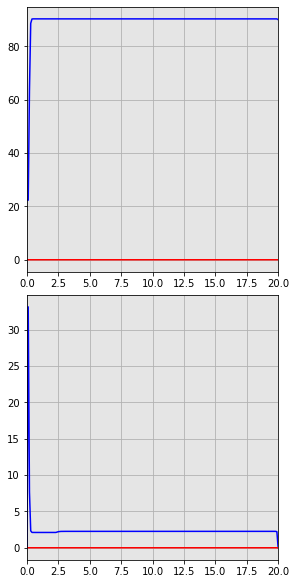

In [17]:
for i in [0]:
    print("------- ", i, exc[i], inh[i])
    
    for j in range(1):
        
        dur = round(d_array[j],1)

        plot_time_array = np.arange(0.,round(dur+aln.params.dt,1),aln.params.dt)

        fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,8) )

        ax[0].plot(plot_time_array, bestState_[i][j][0,0,n_pre-1:-n_post+1], color= 'red')
        ax[0].plot(plot_time_array, bestState_[i][j][0,1,n_pre-1:-n_post+1], color= 'blue')

        ax[1].plot(plot_time_array, bestControl_[i][j][0,1,n_pre-1:-n_post+1], color = 'blue')
        ax[1].plot(plot_time_array, bestControl_[i][j][0,0,n_pre-1:-n_post+1], color = 'red')

        for k in range(2):
            ax[k].set_xlim(0.,dur)
            ax[k].axvspan(dur*t_pen[j], dur, alpha=0.2, color='gray')
        plt.show()

In [ ]:
for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    j = 0
    step = step1

    while j < 2001:
        
        if convergence_[i][j]:
            j += step
            continue

        print('-----', j)

        dur = round(d_array[j],1)
        aln.params.duration = dur
        max_it = int(10000)  

        setinit(initVars[i], aln)
        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        if type(bestControl_[i][j]) == type(None):
            control0 = aln.getZeroControl()
            control0[:,:,:-step] = bestControl_[i][j-step][:,:,n_pre-1:-n_post+1]

        else:
            control0 = bestControl_[i][j][:,:,n_pre-1:-n_post+1]
            
        weights_[i][j] = cost.getParams()

        bestControl_[i][j], bestState_[i][j], cost_[i][j], runtime_, grad_, phi_, phi1_, costnode_[i][j] = aln.A1(
            control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
            prec_variables_ = p_var, transition_time_ = t_pen[j])

        if cost_[i][j][-1] == 0.:
            convergence_[i][j] = True
            if j >= 10:
                step = step2
            if j >=1000:
                step = step3

        print('cost splitting : ', costnode_[i][j][0][0][:2], costnode_[i][j][cost_index][0][:2])

        with open(file_,'wb') as f:
            pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)

-------  0 0.4500000000000001 0.4750000000000002
----- 1
interpolate adjoint :  True True True
initial cost =  20.649518968846312
RUN  0 , total integrated cost =  20.649518968846312
Gradient descend method:  None
RUN  1 , total integrated cost =  20.649518968846312
Control only changes marginally.
RUN  1 , total integrated cost =  20.649518968846312
Improved over  1  iterations in  0.0564702432602644  seconds by  0.0  percent.
cost splitting :  [0.         0.36191941] [3.74988371e-25 2.05756820e+02]
----- 2
interpolate adjoint :  True True True
initial cost =  12.771144463403818
RUN  0 , total integrated cost =  12.771144463403818
Gradient descend method:  None
RUN  1 , total integrated cost =  12.771144463403818
Control only changes marginally.
RUN  1 , total integrated cost =  12.771144463403818
Improved over  1  iterations in  0.05907683353871107  seconds by  0.0  percent.
cost splitting :  [0.         0.01485263] [3.74988371e-25 8.13596055e+01]
----- 3
interpolate adjoint :  True 

In [89]:
bestControl_maxW = np.array( [[None] * len(t_pen)] * len(exc) )
bestState_maxW = np.array( [[None] * len(t_pen)] * len(exc) )
cost_maxW = np.array( [[None] * len(t_pen)] * len(exc) )
costnode_maxW = np.array( [[None] * len(t_pen)] * len(exc) )
weights_maxW = np.array( [[None] * len(t_pen)] * len(exc) )
convergence_maxW = np.array( [[None] * len(t_pen)] * len(exc) )

file_maxW = 'up_Wmax.pickle'

In [90]:
if os.path.isfile(file_maxW) :
    print("file found")
    
    with open(file_maxW,'rb') as f:
        load_array = pickle.load(f)

    bestControl_maxW = load_array[0]
    bestState_maxW = load_array[1]
    cost_maxW = load_array[2]
    costnode_maxW = load_array[3]
    weights_maxW = load_array[4]

file found


In [91]:
bestControl_maxW[0][1:30] = None

In [63]:
for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    j = 0
    
    k = 0

    while not convergence_maxW[i][j]:

        dur = d_array[0]
        aln.params.duration = dur        
        setinit(initVars[i], aln)

        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        control0 = aln.getZeroControl()
        if type(bestControl_maxW[i][j]) == type(None):
            max_it = 10
            control0 = bestControl_[i][0][:,:,n_pre-1:-n_post+1]
            weight_ = ( cost_uncontrolled[i] - sum(costnode_[i][j][0][0][:]) ) / sum( costnode_[i][j][cost_index][0][:] )
            cost.setParams(1., weight_ * factor_we, weight_ * factor_ws)
            weights_maxW[i][j] = cost.getParams()
        else:
            control0 = bestControl_maxW[i][j][:,:,n_pre-1:-n_post+1]
            weight_ = ( cost_uncontrolled[i] - sum(costnode_maxW[i][j][0][0][:]) ) / sum( costnode_maxW[i][j][cost_index][0][:] )
            weight_1 = weight_prev + 0.1 * weight_
            weight_ = ( cost_uncontrolled[i] - sum(costnode_[i][j][0][0][:]) ) / sum( costnode_[i][j][cost_index][0][:] )
            cost.setParams(1., weight_ * factor_we, weight_ * factor_ws)
            weights_maxW[i][j] = cost.getParams()
            max_it = int(100)

        bestControl_maxW[i][j], bestState_maxW[i][j], cost_maxW[i][j], runtime_, grad_, phi_, phi1_, costnode_maxW[i][j] = aln.A1(
            control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
            prec_variables_ = p_var, transition_time_ = t_pen[j])

        if cost_maxW[i][j][2] == 0.:
            convergence_maxW[i][j] = True

        print('cost splitting : ', costnode_[i][j][0][0][:2], costnode_[i][j][cost_index][0][:2])

        with open(file_maxW,'wb') as f:
            pickle.dump([bestControl_maxW, bestState_maxW, cost_maxW, costnode_maxW, weights_maxW], f)
            
        weight_prev = weight_

-------  0 0.4500000000000001 0.4750000000000002
set cost params:  1.0 429.6571231386409 0.0
interpolate adjoint :  True True True
initial cost =  46530.90353535785
RUN  0 , total integrated cost =  46530.90353535785
Gradient descend method:  None
RUN  1 , total integrated cost =  22745.853773998737
RUN  2 , total integrated cost =  17634.882951807052
RUN  3 , total integrated cost =  16371.916901460383
RUN  4 , total integrated cost =  16093.381753167281
RUN  5 , total integrated cost =  16032.508752213133
RUN  6 , total integrated cost =  16018.81616086062
RUN  7 , total integrated cost =  16016.27662891031
RUN  8 , total integrated cost =  16015.778905105526
RUN  9 , total integrated cost =  16015.521515022177
RUN  10 , total integrated cost =  16015.267560302957
RUN  10 , total integrated cost =  16015.267560302957
Improved over  10  iterations in  0.7658105230075307  seconds by  65.58143869238796  percent.
cost splitting :  [  0.         499.29927992] [3.43189402e-07 1.07135671e+0

In [92]:
for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    j = 0
    step = step1

    while j < 2001:
        
        if j == 0:
            j += step
            continue
        
        if j >= 100:
            step = step2
            
        if j >= 1000:
            step = step3
        
        if convergence_maxW[i][j]:
            j += step
            continue

        print('-----', j)

        dur = round(d_array[j],1)
        aln.params.duration = dur
        max_it = int(1000)  

        setinit(initVars[i], aln)
        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        if type(bestControl_maxW[i][j]) == type(None):
            control0 = aln.getZeroControl()
            control0[:,:,:-step] = bestControl_maxW[i][j-step][:,:,n_pre-1:-n_post+1]
            weight_ = ( cost_uncontrolled[i] * (1. - t_pen[0]) / (1. - t_pen[j])
                          - sum(costnode_maxW[i][j-step][0][0][:]) ) / sum( costnode_maxW[i][j-step][cost_index][0][:] )

        else:
            control0 = bestControl_maxW[i][j][:,:,n_pre-1:-n_post+1]
            weight_ = ( cost_uncontrolled[i] * (1. - t_pen[0]) / (1. - t_pen[j])
                           - sum(costnode_maxW[i][j][0][0][:]) ) / sum( costnode_maxW[i][j][cost_index][0][:] )
            
        if j < 5:
            weight_1 = ( cost_uncontrolled[i] - sum(costnode_maxW[i][j-1][0][0][:]) ) / sum( costnode_maxW[i][0][cost_index][0][:] )
            weight_ = weight_1
        elif j < 30:
            weight_1 = ( cost_uncontrolled[i] - sum(costnode_maxW[i][j-1][0][0][:]) ) / sum( costnode_maxW[i][j-1][cost_index][0][:] )
            weight_ = weight_1
        
        cost.setParams(1., weight_ * factor_we, weight_ * factor_ws)
        weights_maxW[i][j] = cost.getParams()
            
        bestControl_maxW[i][j], bestState_maxW[i][j], cost_maxW[i][j], runtime_, grad_, phi_, phi1_, costnode_maxW[i][j] = aln.A1(
            control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
            prec_variables_ = p_var, transition_time_ = t_pen[j])

        if cost_maxW[i][j][2] == 0.:
            convergence_maxW[i][j] = True

        print('cost splitting : ', costnode_maxW[i][j][0][0][:2], costnode_maxW[i][j][cost_index][0][:2])

    with open(file_maxW,'wb') as f:
            pickle.dump([bestControl_maxW, bestState_maxW, cost_maxW, costnode_maxW, weights_maxW], f)          

-------  0 0.4500000000000001 0.4750000000000002
----- 1
set cost params:  1.0 1779.8273450673107 0.0
interpolate adjoint :  True True True
initial cost =  46175.87851254931
RUN  0 , total integrated cost =  46175.87851254931
Gradient descend method:  None
RUN  1 , total integrated cost =  31160.2084120015
RUN  2 , total integrated cost =  31077.160356925117
RUN  3 , total integrated cost =  31075.124674573424
RUN  4 , total integrated cost =  31075.08039589387
RUN  5 , total integrated cost =  31075.078987328234
RUN  6 , total integrated cost =  31075.078953439515
RUN  7 , total integrated cost =  31075.078952005424
RUN  8 , total integrated cost =  31075.078951989162
RUN  9 , total integrated cost =  31075.078951989162
Control only changes marginally.
RUN  9 , total integrated cost =  31075.078951989162
Improved over  9  iterations in  0.663242019014433  seconds by  32.70278779093758  percent.
cost splitting :  [    0.         20722.39427776] [1.32674945e-07 5.81667905e+00]
----- 1
s

RUN  1 , total integrated cost =  28061.48037969472
RUN  2 , total integrated cost =  28061.3697859994
RUN  3 , total integrated cost =  28061.355020221952
RUN  4 , total integrated cost =  28061.34799781001
RUN  5 , total integrated cost =  28061.347997809986
RUN  6 , total integrated cost =  28061.347997809986
Control only changes marginally.
RUN  6 , total integrated cost =  28061.347997809986
Improved over  6  iterations in  0.5258608509902842  seconds by  0.02367199733262737  percent.
cost splitting :  [    0.         16475.16070292] [1.70778671e-07 8.69188916e+00]
----- 7
set cost params:  1.0 1332.9883587150362 0.0
interpolate adjoint :  True True True
initial cost =  28061.347997809986
RUN  0 , total integrated cost =  28061.347997809986
Gradient descend method:  None
RUN  1 , total integrated cost =  28061.347997809986
Control only changes marginally.
RUN  1 , total integrated cost =  28061.347997809986
Improved over  1  iterations in  0.11967085697688162  seconds by  0.0  per

RUN  1 , total integrated cost =  28363.027439334197
Control only changes marginally.
RUN  1 , total integrated cost =  28363.027439334197
Improved over  1  iterations in  0.1145636240253225  seconds by  0.0  percent.
cost splitting :  [    0.         16349.62838598] [1.94475154e-07 8.99660268e+00]
----- 14
set cost params:  1.0 1335.3702604598343 0.0
interpolate adjoint :  True True True
initial cost =  28428.341171434065
RUN  0 , total integrated cost =  28428.341171434065
Gradient descend method:  None
RUN  1 , total integrated cost =  28421.720886579817
RUN  2 , total integrated cost =  28421.33879915243
RUN  3 , total integrated cost =  28421.28949854865
RUN  4 , total integrated cost =  28421.28577770997
RUN  5 , total integrated cost =  28421.285777709963
RUN  6 , total integrated cost =  28421.285777709963
Control only changes marginally.
RUN  6 , total integrated cost =  28421.285777709963
Improved over  6  iterations in  0.5139476050389931  seconds by  0.024818168888415926  p

RUN  1 , total integrated cost =  28744.398690178445
Control only changes marginally.
RUN  1 , total integrated cost =  28744.398690178445
Improved over  1  iterations in  0.13392012397525832  seconds by  0.0  percent.
cost splitting :  [    0.         16317.58353883] [2.30886713e-07 9.30006408e+00]
----- 20
set cost params:  1.0 1336.7880844475183 0.0
interpolate adjoint :  True True True
initial cost =  28825.618390125765
RUN  0 , total integrated cost =  28825.618390125765
Gradient descend method:  None
RUN  1 , total integrated cost =  28816.97950913001
RUN  2 , total integrated cost =  28816.580593381135
RUN  3 , total integrated cost =  28816.514937911103
RUN  4 , total integrated cost =  28816.48780685723
RUN  5 , total integrated cost =  28816.48225517074
RUN  6 , total integrated cost =  28816.48093893088
RUN  7 , total integrated cost =  28816.48091788269
RUN  8 , total integrated cost =  28816.480917785666
RUN  9 , total integrated cost =  28816.480917785666
Control only cha

RUN  1 , total integrated cost =  29210.73631362809
RUN  2 , total integrated cost =  29210.257431692586
RUN  3 , total integrated cost =  29210.210375706003
RUN  4 , total integrated cost =  29210.206590337173
RUN  5 , total integrated cost =  29210.204069882853
RUN  6 , total integrated cost =  29210.20396413735
RUN  7 , total integrated cost =  29210.203964137334
RUN  8 , total integrated cost =  29210.203964137334
Control only changes marginally.
RUN  8 , total integrated cost =  29210.203964137334
Improved over  8  iterations in  0.6940152019960806  seconds by  0.03384170041132961  percent.
cost splitting :  [    0.         16359.31504929] [2.92707880e-07 9.62854006e+00]
----- 26
set cost params:  1.0 1334.6663608511894 0.0
interpolate adjoint :  True True True
initial cost =  29210.203964137334
RUN  0 , total integrated cost =  29210.203964137334
Gradient descend method:  None
RUN  1 , total integrated cost =  29210.203964137334
Control only changes marginally.
RUN  1 , total int

RUN  1 , total integrated cost =  54673.81165404562
Control only changes marginally.
RUN  1 , total integrated cost =  54673.81165404562
Improved over  1  iterations in  0.2768657809938304  seconds by  0.0  percent.
cost splitting :  [    0.        54361.4921491] [4.51587391e-24 2.35697138e-17]
----- 36
set cost params:  1.0 1.3348853466627215e+19 0.0
interpolate adjoint :  True True True
initial cost =  54906.46617172241
RUN  0 , total integrated cost =  54906.46617172241
Gradient descend method:  None
RUN  1 , total integrated cost =  54906.46617172241
Control only changes marginally.
RUN  1 , total integrated cost =  54906.46617172241
Improved over  1  iterations in  0.28535574703710154  seconds by  0.0  percent.
cost splitting :  [    0.         54591.83745518] [4.51587391e-24 2.35697138e-17]
----- 37
set cost params:  1.0 1.3446827127536972e+19 0.0
interpolate adjoint :  True True True
initial cost =  55139.1206893992
RUN  0 , total integrated cost =  55139.1206893992
Gradient des

RUN  1 , total integrated cost =  58396.28393687429
Control only changes marginally.
RUN  1 , total integrated cost =  58396.28393687429
Improved over  1  iterations in  0.2590090619632974  seconds by  0.0  percent.
cost splitting :  [    0.        58047.0170471] [4.51587391e-24 2.35697138e-17]
----- 52
set cost params:  1.0 1.4916432008686828e+19 0.0
interpolate adjoint :  True True True
initial cost =  58628.9384545511
RUN  0 , total integrated cost =  58628.9384545511
Gradient descend method:  None
RUN  1 , total integrated cost =  58628.9384545511
Control only changes marginally.
RUN  1 , total integrated cost =  58628.9384545511
Improved over  1  iterations in  0.26186169602442533  seconds by  0.0  percent.
cost splitting :  [    0.         58277.36235327] [4.51587391e-24 2.35697138e-17]
----- 53
set cost params:  1.0 1.5014405665727345e+19 0.0
interpolate adjoint :  True True True
initial cost =  58861.59297222788
RUN  0 , total integrated cost =  58861.59297222788
Gradient desce

RUN  1 , total integrated cost =  62351.410737379774
Control only changes marginally.
RUN  1 , total integrated cost =  62351.410737379774
Improved over  1  iterations in  0.26952234900090843  seconds by  0.0  percent.
cost splitting :  [    0.         61962.88725247] [4.51587391e-24 2.35697138e-17]
----- 69
set cost params:  1.0 1.658198415876611e+19 0.0
interpolate adjoint :  True True True
initial cost =  62584.065255056565
RUN  0 , total integrated cost =  62584.065255056565
Gradient descend method:  None
RUN  1 , total integrated cost =  62584.065255056565
Control only changes marginally.
RUN  1 , total integrated cost =  62584.065255056565
Improved over  1  iterations in  0.27383681101491675  seconds by  0.0  percent.
cost splitting :  [    0.        62193.2325587] [4.51587391e-24 2.35697138e-17]
----- 70
set cost params:  1.0 1.6679957813523489e+19 0.0
interpolate adjoint :  True True True
initial cost =  62816.719772733355
RUN  0 , total integrated cost =  62816.719772733355
Gr

RUN  1 , total integrated cost =  66073.88302020845
Control only changes marginally.
RUN  1 , total integrated cost =  66073.88302020845
Improved over  1  iterations in  0.33908321196213365  seconds by  0.0  percent.
cost splitting :  [    0.         65648.41215239] [4.51587391e-24 2.35697138e-17]
----- 85
set cost params:  1.0 1.8149562621616855e+19 0.0
interpolate adjoint :  True True True
initial cost =  66306.53753788525
RUN  0 , total integrated cost =  66306.53753788525
Gradient descend method:  None
RUN  1 , total integrated cost =  66306.53753788525
Control only changes marginally.
RUN  1 , total integrated cost =  66306.53753788525
Improved over  1  iterations in  0.3094116990105249  seconds by  0.0  percent.
cost splitting :  [    0.         65878.75745866] [4.51587391e-24 2.35697138e-17]
----- 86
set cost params:  1.0 1.8247536274602916e+19 0.0
interpolate adjoint :  True True True
initial cost =  66539.19205556205
RUN  0 , total integrated cost =  66539.19205556205
Gradient

RUN  1 , total integrated cost =  72122.90047980506
Control only changes marginally.
RUN  1 , total integrated cost =  72122.90047980506
Improved over  1  iterations in  0.3261914980248548  seconds by  0.0  percent.
cost splitting :  [    0.         71637.39011626] [4.51587391e-24 2.35697138e-17]
----- 120
set cost params:  1.0 2.1578640402099122e+19 0.0
interpolate adjoint :  True True True
initial cost =  74449.44565657299
RUN  0 , total integrated cost =  74449.44565657299
Gradient descend method:  None
RUN  1 , total integrated cost =  74449.44565657299
Control only changes marginally.
RUN  1 , total integrated cost =  74449.44565657299
Improved over  1  iterations in  0.3364040969754569  seconds by  0.0  percent.
cost splitting :  [    0.         73940.84317985] [4.51587391e-24 2.35697138e-17]
----- 130
set cost params:  1.0 2.2558376879408587e+19 0.0
interpolate adjoint :  True True True
initial cost =  76775.99083334093
RUN  0 , total integrated cost =  76775.99083334093
Gradien

RUN  1 , total integrated cost =  109347.6233080919
Control only changes marginally.
RUN  1 , total integrated cost =  109347.6233080919
Improved over  1  iterations in  0.23486391501501203  seconds by  0.0  percent.
cost splitting :  [     0.         108492.63911884] [4.51587391e-24 2.35697138e-17]
----- 280
set cost params:  1.0 3.725442506830494e+19 0.0
interpolate adjoint :  True True True
initial cost =  111674.16848485982
RUN  0 , total integrated cost =  111674.16848485982
Gradient descend method:  None
RUN  1 , total integrated cost =  111674.16848485982
Control only changes marginally.
RUN  1 , total integrated cost =  111674.16848485982
Improved over  1  iterations in  0.19998030900023878  seconds by  0.0  percent.
cost splitting :  [     0.         110796.09217859] [4.51587391e-24 2.35697138e-17]
----- 290
set cost params:  1.0 3.823416172144402e+19 0.0
interpolate adjoint :  True True True
initial cost =  114000.71366162774
RUN  0 , total integrated cost =  114000.713661627

RUN  1 , total integrated cost =  146572.34613637874
Control only changes marginally.
RUN  1 , total integrated cost =  146572.34613637874
Improved over  1  iterations in  0.3687400530325249  seconds by  0.0  percent.
cost splitting :  [     0.         145347.88807615] [4.51587391e-24 2.35697138e-17]
----- 440
set cost params:  1.0 5.293021148816529e+19 0.0
interpolate adjoint :  True True True
initial cost =  148898.89131314663
RUN  0 , total integrated cost =  148898.89131314663
Gradient descend method:  None
RUN  1 , total integrated cost =  148898.89131314663
Control only changes marginally.
RUN  1 , total integrated cost =  148898.89131314663
Improved over  1  iterations in  0.3602854550117627  seconds by  0.0  percent.
cost splitting :  [     0.       147651.341136] [4.51587391e-24 2.35697138e-17]
----- 450
set cost params:  1.0 5.390994813927436e+19 0.0
interpolate adjoint :  True True True
initial cost =  151225.43648991454
RUN  0 , total integrated cost =  151225.43648991454
G

RUN  1 , total integrated cost =  183797.06896466552
Control only changes marginally.
RUN  1 , total integrated cost =  183797.06896466552
Improved over  1  iterations in  0.31841175298905  seconds by  0.0  percent.
cost splitting :  [     0.         182203.13703362] [4.51587391e-24 2.35697138e-17]
----- 600
set cost params:  1.0 6.860599790564495e+19 0.0
interpolate adjoint :  True True True
initial cost =  186123.61414143347
RUN  0 , total integrated cost =  186123.61414143347
Gradient descend method:  None
RUN  1 , total integrated cost =  186123.61414143347
Control only changes marginally.
RUN  1 , total integrated cost =  186123.61414143347
Improved over  1  iterations in  0.2739726229920052  seconds by  0.0  percent.
cost splitting :  [     0.         184506.59009346] [4.51587391e-24 2.35697138e-17]
----- 610
set cost params:  1.0 6.958573455672686e+19 0.0
interpolate adjoint :  True True True
initial cost =  188450.15931820142
RUN  0 , total integrated cost =  188450.15931820142

RUN  1 , total integrated cost =  221021.79179295237
Control only changes marginally.
RUN  1 , total integrated cost =  221021.79179295237
Improved over  1  iterations in  0.3200864699902013  seconds by  0.0  percent.
cost splitting :  [     0.         219058.38599109] [4.51587391e-24 2.35697138e-17]
----- 760
set cost params:  1.0 8.42817843226912e+19 0.0
interpolate adjoint :  True True True
initial cost =  223348.33696972026
RUN  0 , total integrated cost =  223348.33696972026
Gradient descend method:  None
RUN  1 , total integrated cost =  223348.33696972026
Control only changes marginally.
RUN  1 , total integrated cost =  223348.33696972026
Improved over  1  iterations in  0.2965308660059236  seconds by  0.0  percent.
cost splitting :  [     0.         221361.83905093] [4.51587391e-24 2.35697138e-17]
----- 770
set cost params:  1.0 8.526152097375335e+19 0.0
interpolate adjoint :  True True True
initial cost =  225674.88214648818
RUN  0 , total integrated cost =  225674.8821464881

RUN  1 , total integrated cost =  258246.51462123916
Control only changes marginally.
RUN  1 , total integrated cost =  258246.51462123916
Improved over  1  iterations in  0.48626712895929813  seconds by  0.0  percent.
cost splitting :  [     0.         255913.63494857] [4.51587391e-24 2.35697138e-17]
----- 920
set cost params:  1.0 9.995757073946332e+19 0.0
interpolate adjoint :  True True True
initial cost =  260573.05979800713
RUN  0 , total integrated cost =  260573.05979800713
Gradient descend method:  None
RUN  1 , total integrated cost =  260573.05979800713
Control only changes marginally.
RUN  1 , total integrated cost =  260573.05979800713
Improved over  1  iterations in  0.4941021740087308  seconds by  0.0  percent.
cost splitting :  [     0.         258217.08800841] [4.51587391e-24 2.35697138e-17]
----- 930
set cost params:  1.0 1.0093730739050078e+20 0.0
interpolate adjoint :  True True True
initial cost =  262899.60497477505
RUN  0 , total integrated cost =  262899.6049747

RUN  1 , total integrated cost =  442043.58358590544
Control only changes marginally.
RUN  1 , total integrated cost =  442043.58358590544
Improved over  1  iterations in  0.6945123129989952  seconds by  0.0  percent.
cost splitting :  [     0.         437886.42667615] [4.51587391e-24 2.35697138e-17]
----- 1800
set cost params:  1.0 1.8617439603013812e+20 0.0
interpolate adjoint :  True True True
initial cost =  465309.0353535845
RUN  0 , total integrated cost =  465309.0353535845
Gradient descend method:  None
RUN  1 , total integrated cost =  465309.0353535845
Control only changes marginally.
RUN  1 , total integrated cost =  465309.0353535845
Improved over  1  iterations in  0.7238180689746514  seconds by  0.0  percent.
cost splitting :  [     0.         460920.95727458] [4.51587391e-24 2.35697138e-17]
----- 1900
set cost params:  1.0 1.9597176254039658e+20 0.0
interpolate adjoint :  True True True
initial cost =  488574.487121264
RUN  0 , total integrated cost =  488574.487121264
G

RUN  3 , total integrated cost =  27419.88408331564
RUN  4 , total integrated cost =  27419.799435835506
RUN  5 , total integrated cost =  27419.77272564645
RUN  6 , total integrated cost =  27419.755653210148
RUN  7 , total integrated cost =  27419.73227351473
RUN  8 , total integrated cost =  27419.73203944568
RUN  9 , total integrated cost =  27419.732039445673
RUN  10 , total integrated cost =  27419.732039445673
Control only changes marginally.
RUN  10 , total integrated cost =  27419.732039445673
Improved over  10  iterations in  0.7493071260396391  seconds by  38.28366115564784  percent.
cost splitting :  [    0.         17381.46096051] [5.96403233e-11 6.69337564e+00]
----- 5
set cost params:  1.0 1499.7322152433617 0.0
interpolate adjoint :  True True True
initial cost =  27419.732039445673
RUN  0 , total integrated cost =  27419.732039445673
Gradient descend method:  None
RUN  1 , total integrated cost =  27419.732039445673
Control only changes marginally.
RUN  1 , total integ

KeyboardInterrupt: 

-------  0 0.4500000000000001 0.4750000000000002


NameError: name 'bestState_maxW' is not defined

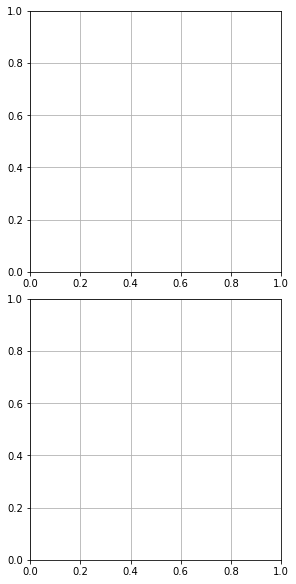

In [15]:
for i in [0]:
    print("------- ", i, exc[i], inh[i])
    
    for j in range(1):
        
        dur = round(d_array[j],1)

        plot_time_array = np.arange(0.,round(dur+aln.params.dt,1),aln.params.dt)

        fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,8) )

        ax[0].plot(plot_time_array, bestState_maxW[i][j][0,0,n_pre-1:-n_post+1], color= 'red')
        ax[0].plot(plot_time_array, bestState_maxW[i][j][0,1,n_pre-1:-n_post+1], color= 'blue')

        ax[1].plot(plot_time_array, bestControl_maxW[i][j][0,1,n_pre-1:-n_post+1], color = 'blue')
        ax[1].plot(plot_time_array, bestControl_maxW[i][j][0,0,n_pre-1:-n_post+1], color = 'red')

        for k in range(2):
            ax[k].set_xlim(0.,dur)
            ax[k].axvspan(dur*t_pen[j], dur, alpha=0.2, color='gray')
        plt.show()